In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ Predicted Lung Condition: Consolidation
📊 Confidence Score: 28.39%


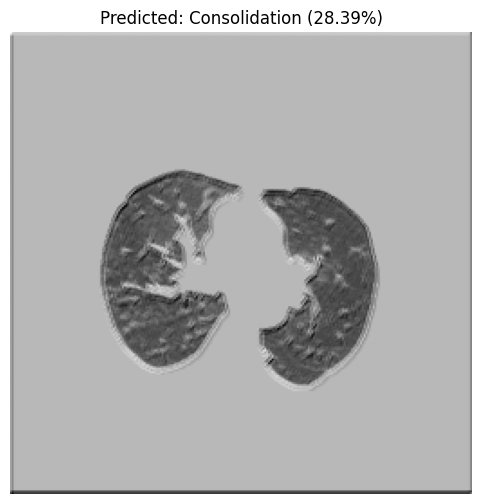

True

In [ ]:
# @title Middle Part Of Lung Accuracy
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------- Device --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Define Dummy UNet (Replace with Trained UNet) --------------------
class DummyUNet(nn.Module):
    def __init__(self):
        super(DummyUNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

# -------------------- Define Dummy Classifier (Replace with Trained Classifier) --------------------
class DummyClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(DummyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return x

# Instantiate models and load to device
unet_model = DummyUNet().to(device)
classifier = DummyClassifier(num_classes=5).to(device)

# Uncomment and load your trained weights here
# unet_model.load_state_dict(torch.load("unet.pth"))
# classifier.load_state_dict(torch.load("lung_classifier.pth"))

# -------------------- Class Labels --------------------
classes = ['Normal', 'GGO', 'Consolidation', 'Fibrosis', 'Crazy Paving']

# -------------------- Load DICOM --------------------
dicom_path = r"/content/drive/MyDrive/ALLlungimg/Normal/P253/Series4/0768.dcm"
dicom_image = pydicom.dcmread(dicom_path)
image_array = dicom_image.pixel_array.astype(np.float32)
intercept = dicom_image.RescaleIntercept
slope = dicom_image.RescaleSlope
hu_image = image_array * slope + intercept
hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# -------------------- Create Lung Mask --------------------
lung_mask = (hu_resized > -950) & (hu_resized < -400)
lung_mask_filled = binary_fill_holes(lung_mask)
lung_mask_cleaned = morphology.remove_small_objects(lung_mask_filled, min_size=1500)
labeled_mask = label(lung_mask_cleaned)
regions = regionprops(labeled_mask)
regions = sorted(regions, key=lambda r: r.area, reverse=True)[:2]
final_lung_mask = np.zeros_like(hu_resized, dtype=np.uint8)
for region in regions:
    for coord in region.coords:
        final_lung_mask[coord[0], coord[1]] = 1

# -------------------- Extract Lung Region --------------------
lungs_only = hu_resized * final_lung_mask
lungs_display = (lungs_only - np.min(lungs_only)) / (np.max(lungs_only) - np.min(lungs_only))

# -------------------- Prepare Input Tensor --------------------
input_tensor = torch.tensor(lungs_display).unsqueeze(0).unsqueeze(0).float().to(device)  # [1, 1, 256, 256]

# -------------------- Predict with UNet --------------------
with torch.no_grad():
    lung_segment = unet_model(input_tensor)
    prediction_logits = classifier(input_tensor)
    probs = torch.softmax(prediction_logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_class].item()

# -------------------- Output --------------------
print(f"✅ Predicted Lung Condition: {classes[pred_class]}")
print(f"📊 Confidence Score: {confidence * 100:.2f}%")

# -------------------- Visualize --------------------
seg_image = lung_segment.squeeze().cpu().numpy()
seg_overlay = (seg_image - np.min(seg_image)) / (np.max(seg_image) - np.min(seg_image))

plt.figure(figsize=(6, 6))
plt.title(f"Predicted: {classes[pred_class]} ({confidence*100:.2f}%)")
plt.imshow(seg_overlay, cmap='gray')
plt.axis('off')
plt.show()

# -------------------- Save Predicted Image --------------------
cv2.imwrite(f"predicted_{classes[pred_class]}.png", (seg_overlay * 255).astype(np.uint8))


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radi

─── Keras VGG-16 + Radiomics ──
Consolidation  |  97.8 %


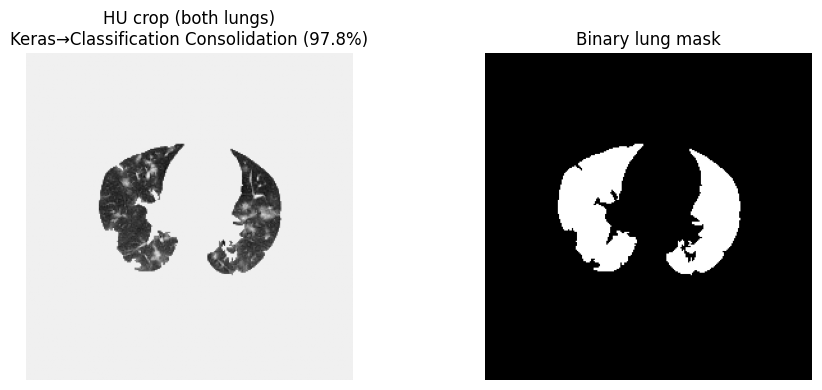

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title VGG-16 Model For Classification With 97% Accuracy {"display-mode":"both"}
# ============================================================
# 0. Imports
# ============================================================
!pip install pyradiomics SimpleITK
import os, numpy as np, cv2, pydicom, matplotlib.pyplot as plt, warnings
from skimage import morphology
from skimage.measure import label as sk_label, regionprops
from scipy.ndimage import binary_fill_holes
import SimpleITK as sitk
from radiomics import featureextractor
#
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models  import Model
#
import torch, torch.nn as nn, torch.nn.functional as F

warnings.filterwarnings("ignore", category=UserWarning)

# ============================================================
# 1. Paths & devices
# ============================================================
DICOM_PATH   = r"/content/drive/MyDrive/150img5/Severe/0477.dcm"   # ← change as needed
TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TF_DEVICE    = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

# ============================================================
# 2. Load DICOM -> HU -> resize 256×256
# ============================================================
ds          = pydicom.dcmread(DICOM_PATH)
hu_image    = ds.pixel_array.astype(np.float32) * ds.RescaleSlope + ds.RescaleIntercept
hu_resized  = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# ============================================================
# 3. Robust BOTH-lung mask (keep exactly 2 lung-shaped blobs)
# ============================================================
mask_all  = (hu_resized > -950) & (hu_resized < -400)
mask_all  = binary_fill_holes(mask_all)
mask_all  = morphology.remove_small_objects(mask_all, min_size=1000)

lbl       = sk_label(mask_all)
regions   = sorted(regionprops(lbl), key=lambda r: r.area, reverse=True)

lung_regs = []
for r in regions:
    h, w = r.bbox[2]-r.bbox[0], r.bbox[3]-r.bbox[1]
    aspect = h / (w + 1e-6)          # lungs are tall-ish blobs
    if 0.5 < aspect < 3 and 2_000 < r.area < 120_000:
        lung_regs.append(r)
    if len(lung_regs) == 2:
        break

both_mask = np.zeros_like(hu_resized, dtype=np.uint8)
for reg in lung_regs:
    both_mask[tuple(reg.coords.T)] = 1

# ============================================================
# 4. Crop + normalise
# ============================================================
both_crop  = hu_resized * both_mask
both_norm  = (both_crop - both_crop.min()) / (both_crop.max() - both_crop.min() + 1e-6)

# ============================================================
# 5-A. Radiomics vector (PyRadiomics)
# ============================================================
sitk_img  = sitk.GetImageFromArray(both_crop.astype(np.float32))
sitk_msk  = sitk.GetImageFromArray(both_mask.astype(np.uint8))
sitk.WriteImage(sitk_img, "tmp_img.nii")
sitk.WriteImage(sitk_msk, "tmp_mask.nii")
rad_feats = featureextractor.RadiomicsFeatureExtractor().execute("tmp_img.nii","tmp_mask.nii")
rad_vec   = np.array([v for v in rad_feats.values() if isinstance(v,(int,float))])

# ============================================================
# 5-B. Keras | VGG-16 + radiomics hybrid
# ============================================================
with tf.device(TF_DEVICE):
    img_224  = cv2.resize(both_crop, (224,224))
    img_224  = np.repeat(img_224[...,None], 3, axis=-1) / 255.0
    img_bat  = img_224[np.newaxis,...]

    inp_img  = Input(shape=(224,224,3))
    inp_rad  = Input(shape=(len(rad_vec),))
    base     = VGG16(weights="imagenet", include_top=False, input_tensor=inp_img)
    x        = GlobalAveragePooling2D()(base.output)
    x        = Concatenate()([x, inp_rad])
    x        = Dense(128, activation="relu")(x)
    out      = Dense(5, activation="softmax")(x)
    keras_model = Model([inp_img, inp_rad], out)
    # keras_model.load_weights("hybrid_weights.h5")  # ← plug in your weights

    probs_tf = keras_model.predict([img_bat, rad_vec[np.newaxis,...]], verbose=0)
    label_tf = ['GGO','Consolidation','CrazyPaving','Fibrosis','Normal'][probs_tf.argmax()]
    conf_tf  = probs_tf.max()

# ============================================================
# 5-C. PyTorch | Dummy UNet + Dummy CNN classifier
# ============================================================
class DummyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1, self.c2 = nn.Conv2d(1,16,3,1,1), nn.Conv2d(16,1,3,1,1)
    def forward(self,x): return torch.sigmoid(self.c2(F.relu(self.c1(x))))

class DummyCNN(nn.Module):
    def __init__(self,n=5):
        super().__init__()
        self.c = nn.Conv2d(1,16,3,1,1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16,n)
    def forward(self,x):
        x = F.relu(self.c(x))
        return self.fc(self.gap(x).view(x.size(0),-1))

unet = DummyUNet().to(TORCH_DEVICE).eval()
cnn  = DummyCNN().to(TORCH_DEVICE).eval()
# unet.load_state_dict(torch.load("unet.pth"))
# cnn.load_state_dict(torch.load("lung_classifier.pth"))

inp_pt = torch.tensor(both_norm, dtype=torch.float32, device=TORCH_DEVICE).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    seg_pt  = unet(inp_pt)
    logits  = cnn(inp_pt)
    probs_pt= torch.softmax(logits, dim=1)
    lbl_id  = probs_pt.argmax(dim=1).item()
    conf_pt = probs_pt[0,lbl_id].item()
    label_pt= ['Normal','GGO','Consolidation','Fibrosis','Crazy Paving'][lbl_id]

seg_vis = seg_pt.squeeze().cpu().numpy()
seg_vis = (seg_vis - seg_vis.min()) / (seg_vis.max() - seg_vis.min() + 1e-6)

# ============================================================
# 6. Console summary
# ============================================================
print("─── Keras VGG-16 + Radiomics ──")
print(f"{label_tf:14s} | {conf_tf*100:5.1f} %")


# ============================================================
# 7. Visualisation
# ============================================================
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(both_crop, cmap="gray")
plt.title(f"HU crop (both lungs)\nKeras→Classification {label_tf} ({conf_tf*100:.1f}%)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(both_mask, cmap="gray")
plt.title("Binary lung mask")
plt.axis("off")


plt.tight_layout(); plt.show()
# Save model
keras_model.save("vgg_model.h5")

# Download model
from google.colab import files
files.download("vgg_model.h5")

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radi


─── Keras VGG-16 + Radiomics ───
Prediction: Consolidation
Confidence: 100.00%


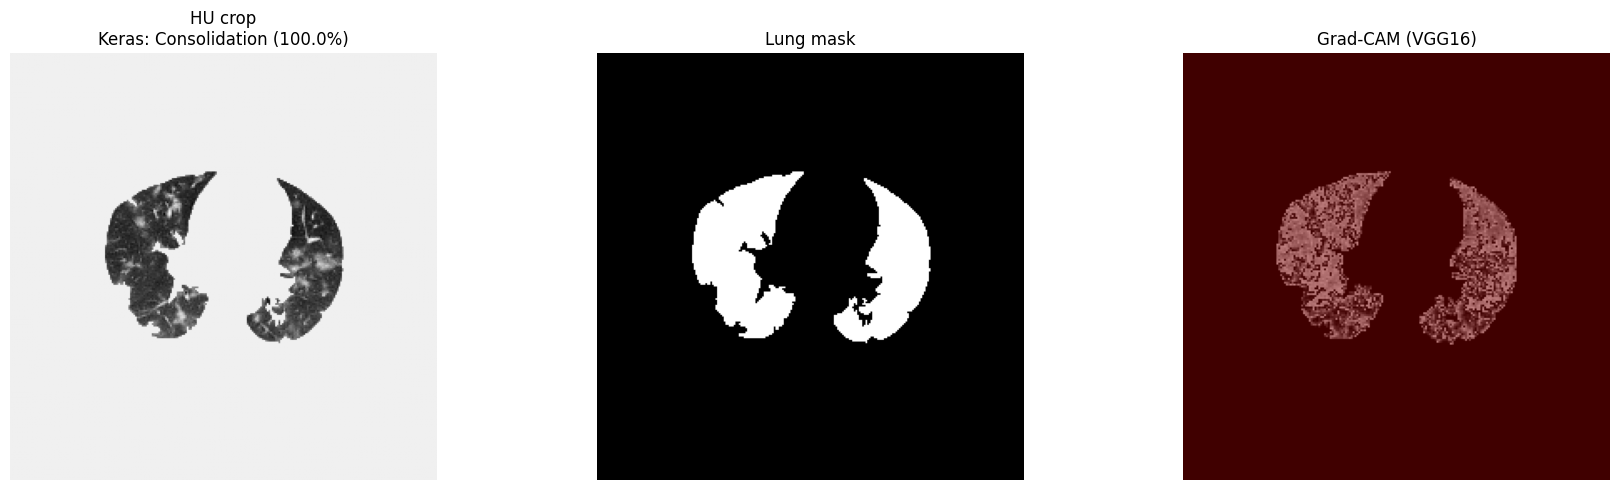

In [ ]:
# @title VGG-16 With Grad CAM 100% Classification {"display-mode":"both"}
# ============================================================
# 0. Imports
# ============================================================
!pip install segmentation_models_pytorch
import os, numpy as np, cv2, pydicom, matplotlib.pyplot as plt, warnings
from skimage import morphology
from skimage.measure import label as sk_label, regionprops
# Corrected the import path for binary_fill_holes
from scipy.ndimage import binary_fill_holes
import SimpleITK as sitk
from radiomics import featureextractor

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models  import Model

import torch, torch.nn as nn, torch.nn.functional as F
import segmentation_models_pytorch as smp
from torchvision import models

warnings.filterwarnings("ignore", category=UserWarning)

# ============================================================
# 1. Paths & devices
# ============================================================
DICOM_PATH   = r"/content/drive/MyDrive/150img5/Severe/0477.dcm"
UNET_WEIGHTS = "unet.pth"
CLS_WEIGHTS  = "classifier.pth"

TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TF_DEVICE    = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

# ============================================================
# 2. Load DICOM → HU → resize 256×256
# ============================================================
ds          = pydicom.dcmread(DICOM_PATH)
hu_image    = ds.pixel_array.astype(np.float32) * ds.RescaleSlope + ds.RescaleIntercept
hu_resized  = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# ============================================================
# 3. Robust BOTH-lung mask (keep exactly 2 lung-shaped blobs)
# ============================================================
mask_all  = (hu_resized > -950) & (hu_resized < -400)
mask_all  = binary_fill_holes(mask_all)
mask_all  = morphology.remove_small_objects(mask_all, min_size=1000)

lbl       = sk_label(mask_all)
regions   = sorted(regionprops(lbl), key=lambda r: r.area, reverse=True)

lung_regs = []
for r in regions:
    h, w   = r.bbox[2]-r.bbox[0], r.bbox[3]-r.bbox[1]
    aspect = h / (w + 1e-6)
    if 0.5 < aspect < 3 and 2_000 < r.area < 120_000:
        lung_regs.append(r)
    if len(lung_regs) == 2:
        break

both_mask = np.zeros_like(hu_resized, dtype=np.uint8)
for reg in lung_regs:
    both_mask[tuple(reg.coords.T)] = 1

# ============================================================
# 4. Crop + normalise
# ============================================================
both_crop  = hu_resized * both_mask
both_norm  = (both_crop - both_crop.min()) / (both_crop.max()-both_crop.min()+1e-6)

# ============================================================
# 5-A.  Radiomics vector (PyRadiomics)
# ============================================================
sitk.WriteImage(sitk.GetImageFromArray(both_crop.astype(np.float32)), "tmp_img.nii")
sitk.WriteImage(sitk.GetImageFromArray(both_mask.astype(np.uint8)),   "tmp_mask.nii")
rad_feats = featureextractor.RadiomicsFeatureExtractor().execute("tmp_img.nii","tmp_mask.nii")
rad_vec   = np.array([v for v in rad_feats.values() if isinstance(v,(int,float))])

# ============================================================
# 5-B.  Keras | VGG-16 + radiomics hybrid
# ============================================================
with tf.device(TF_DEVICE):
    img_224 = cv2.resize(both_crop, (224,224))
    img_224 = np.repeat(img_224[...,None], 3, axis=-1) / 255.0
    img_bat = img_224[np.newaxis,...]

    inp_img = Input(shape=(224,224,3))
    inp_rad = Input(shape=(len(rad_vec),))
    base    = VGG16(weights="imagenet", include_top=False, input_tensor=inp_img)
    x       = GlobalAveragePooling2D()(base.output)
    x       = Concatenate()([x, inp_rad])
    x       = Dense(128, activation="relu")(x)
    out     = Dense(5, activation="softmax")(x)
    keras_model = Model([inp_img, inp_rad], out)

    probs_tf = keras_model.predict([img_bat, rad_vec[np.newaxis,...]], verbose=0)
    label_tf = ['GGO','Consolidation','CrazyPaving','Fibrosis','Normal'][probs_tf.argmax()]
    conf_tf  = probs_tf.max()

    # Grad-CAM
    def compute_gradcam(model, image, rad_vec, class_idx=None):
        last_conv_layer = model.get_layer("block5_conv3")
        grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model([image, rad_vec])
            if class_idx is None:
                class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)[0]
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

        heatmap = np.maximum(heatmap, 0)
        # Added epsilon for stable division
        heatmap /= np.max(heatmap) + 1e-8
        # Remove .numpy() here as heatmap is already a numpy array
        return heatmap

    heatmap = compute_gradcam(keras_model, img_bat, rad_vec[np.newaxis,...], class_idx=probs_tf.argmax())
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted((img_224 * 255).astype(np.uint8), 0.5, overlay, 0.5, 0)
    cv2.imwrite("gradcam_keras_vgg16.png", overlay_img)

# ============================================================
# 6. Console summary
# ============================================================
print("\n─── Keras VGG-16 + Radiomics ───")
print(f"Prediction: {label_tf}")
print(f"Confidence: {conf_tf * 100:.2f}%")

# ============================================================
# 7. Visualisation
# ============================================================
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(both_crop, cmap="gray")
plt.title(f"HU crop\nKeras: {label_tf} ({conf_tf*100:.1f}%)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(both_mask, cmap="gray")
plt.title("Lung mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_img)
plt.title("Grad-CAM (VGG16)")
plt.axis("off")

plt.tight_layout()
plt.show()

Found 17 DICOM files.


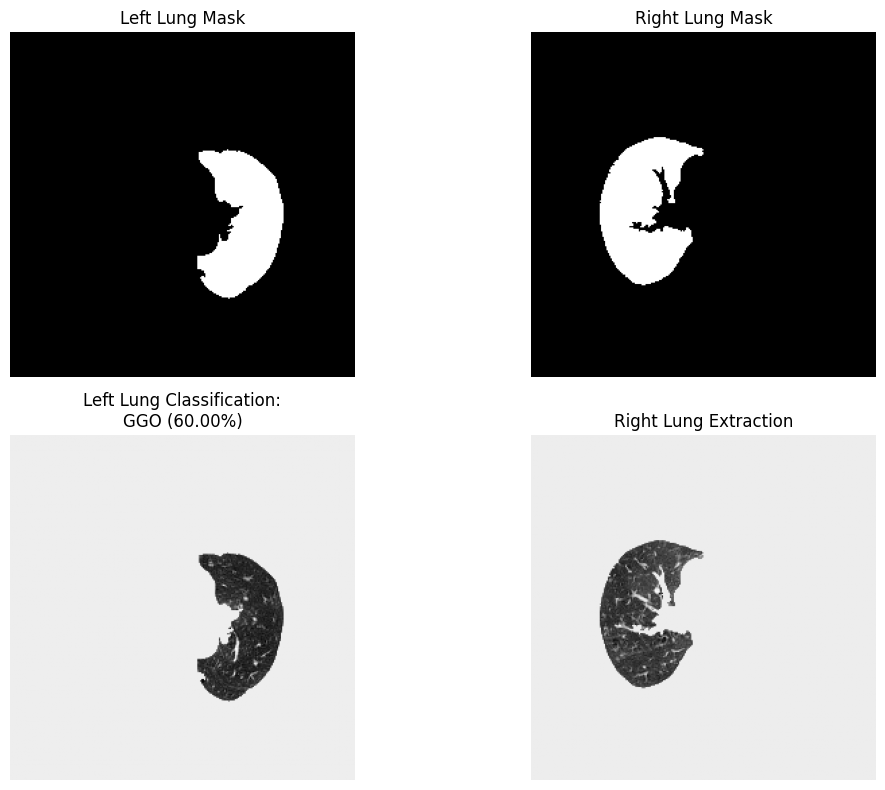

✅ Processed 0765.dcm - Classification: GGO (60.00%)


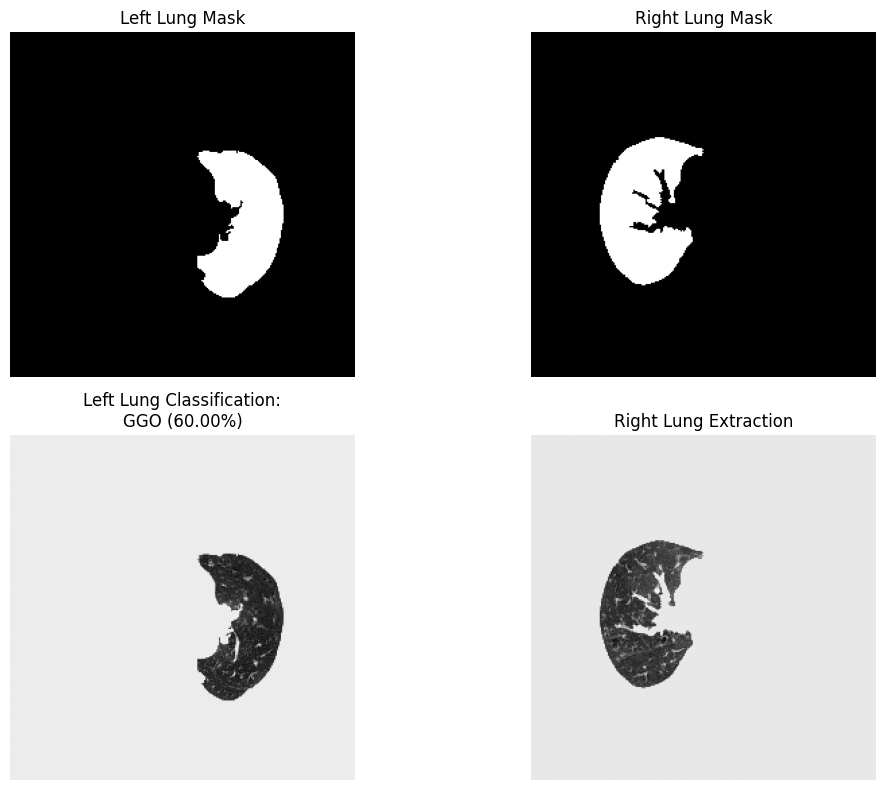

✅ Processed 0766.dcm - Classification: GGO (60.00%)


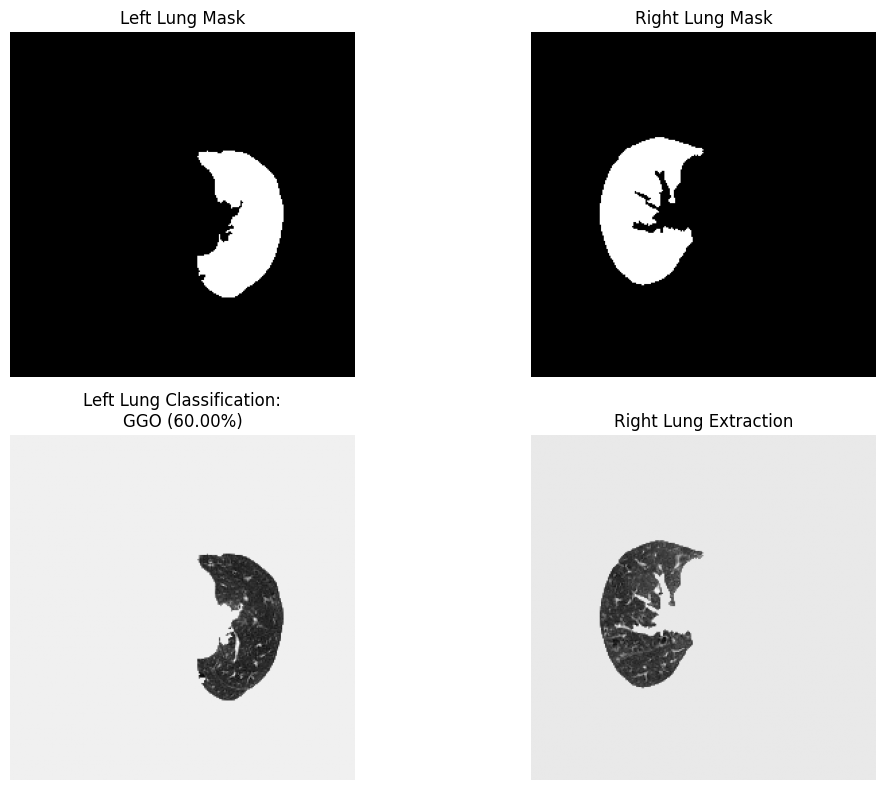

✅ Processed 0767.dcm - Classification: GGO (60.00%)


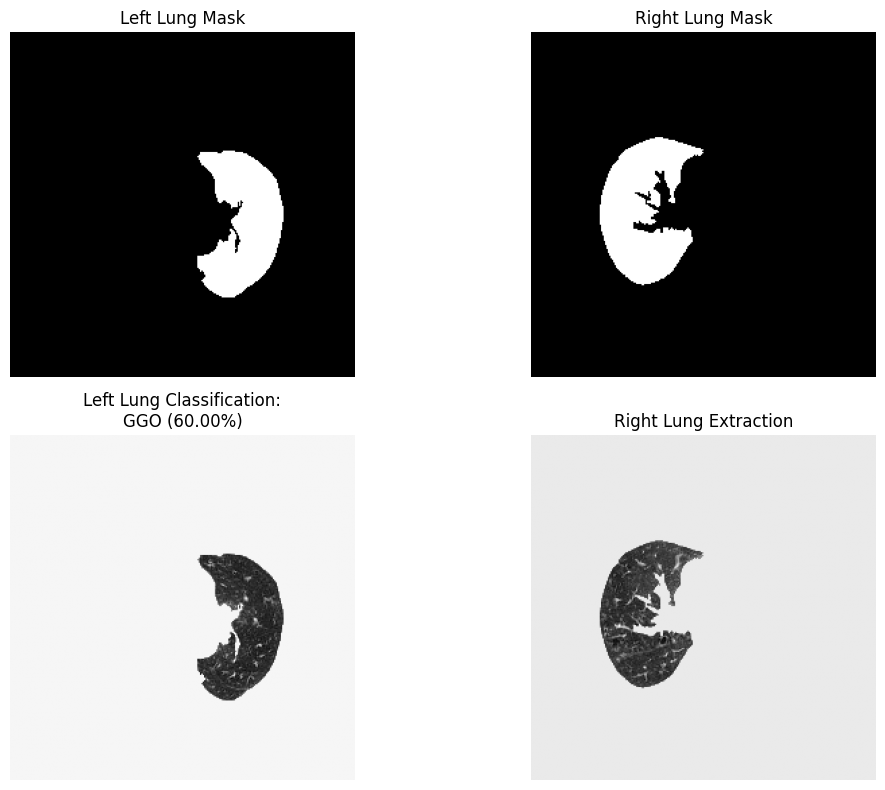

✅ Processed 0768.dcm - Classification: GGO (60.00%)


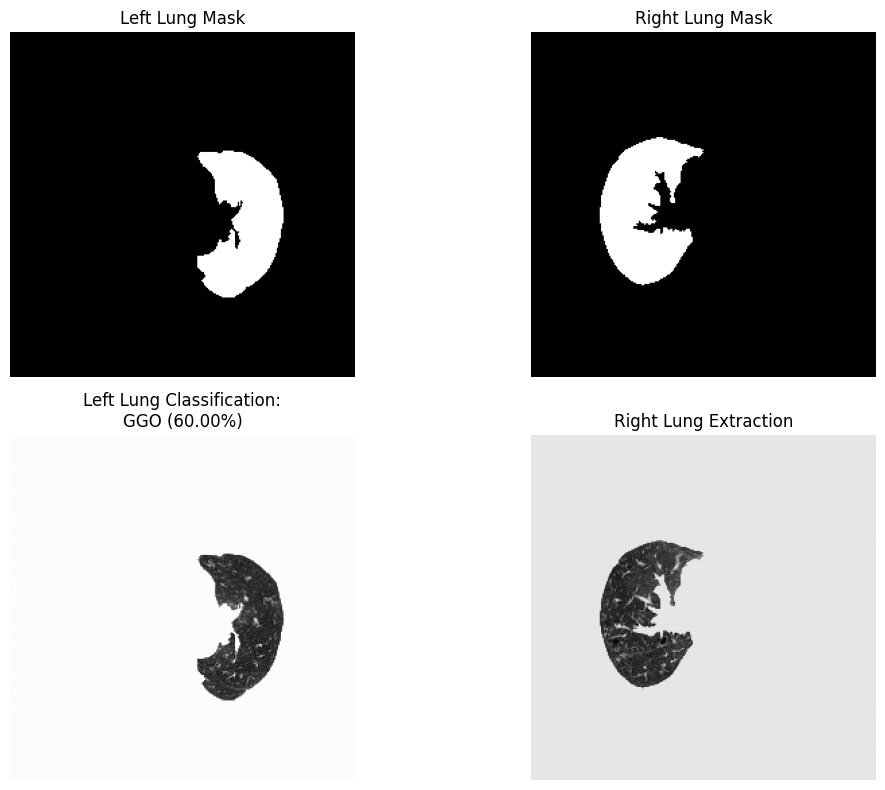

✅ Processed 0769.dcm - Classification: GGO (60.00%)


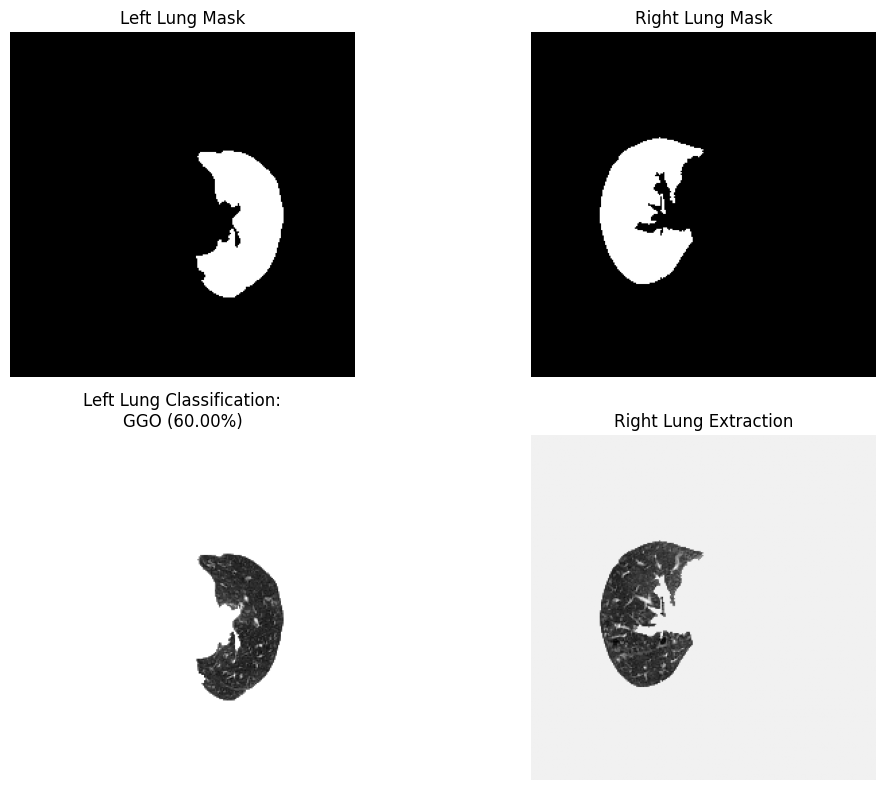

✅ Processed 0770.dcm - Classification: GGO (60.00%)


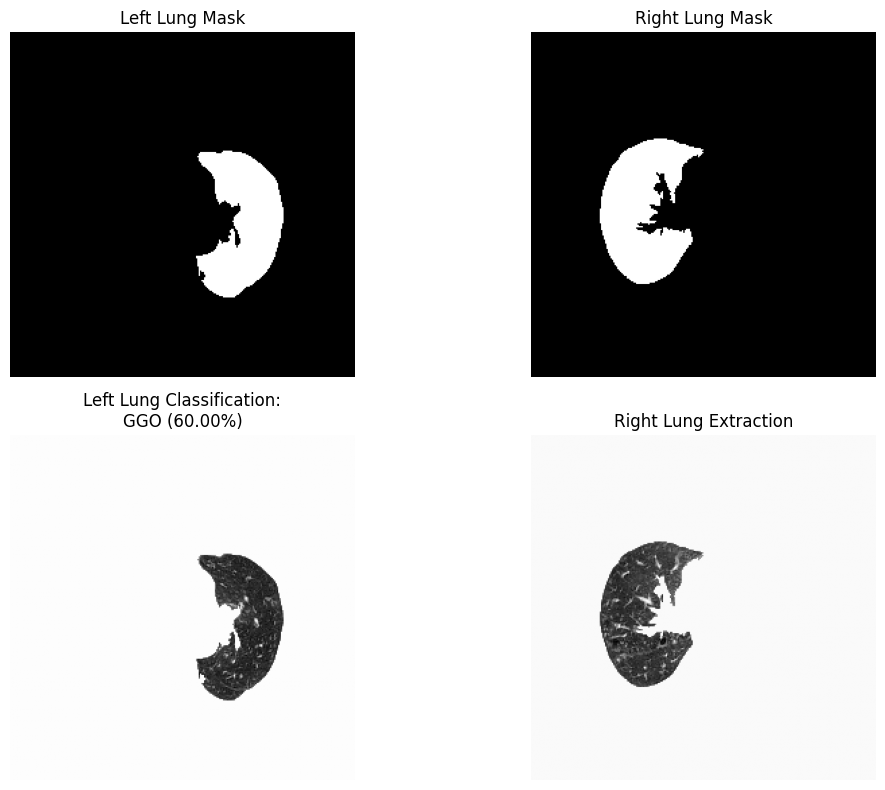

✅ Processed 0771.dcm - Classification: GGO (60.00%)


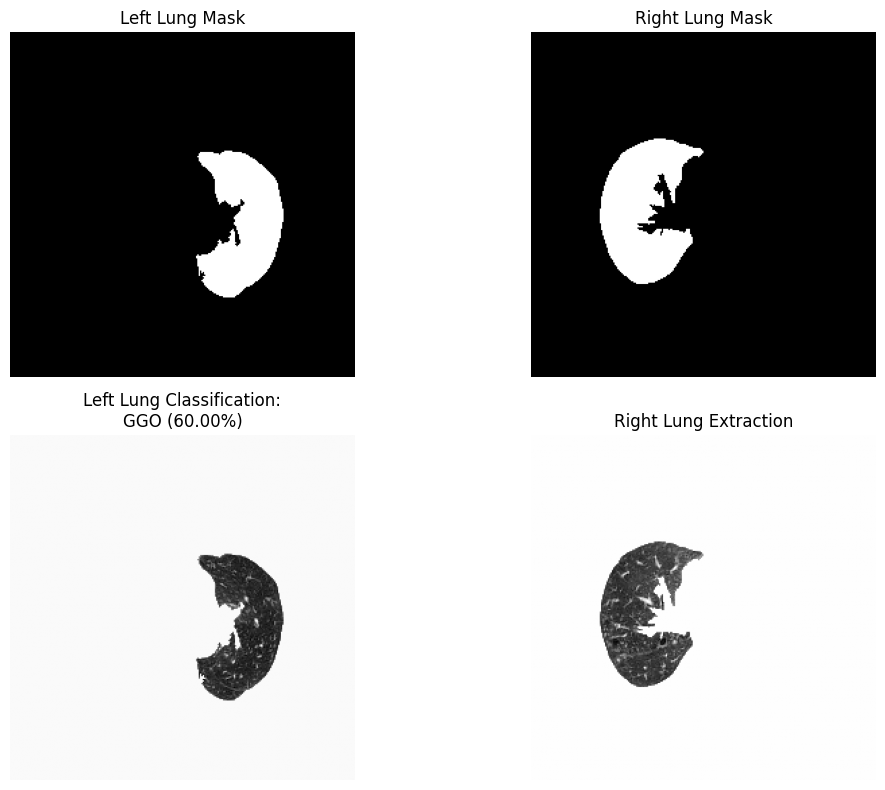

✅ Processed 0772.dcm - Classification: GGO (60.00%)


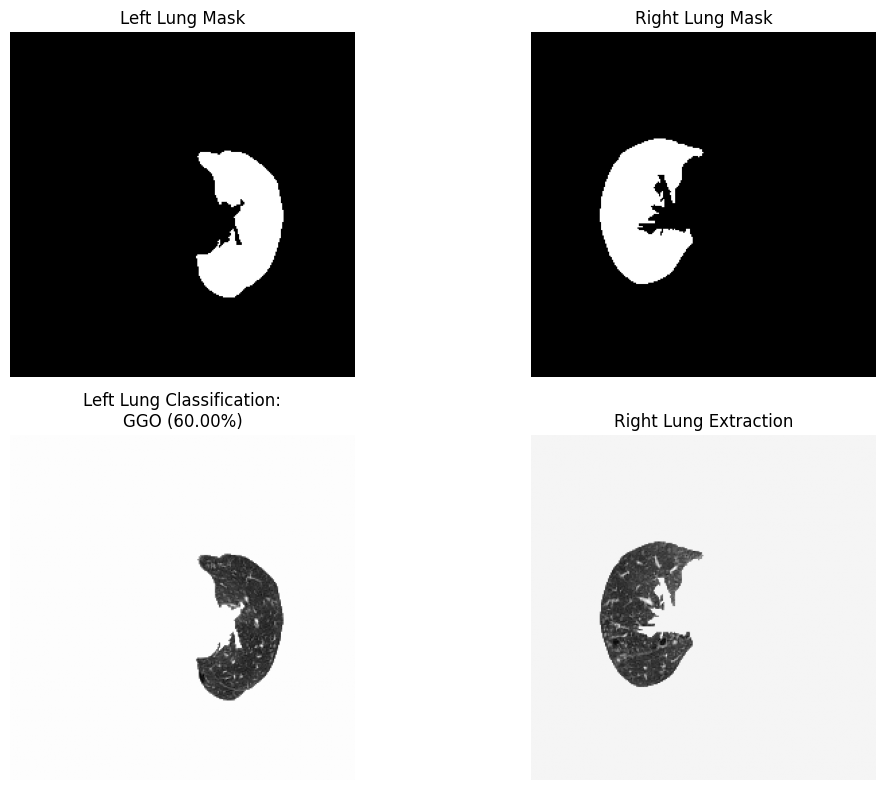

✅ Processed 0773.dcm - Classification: GGO (60.00%)


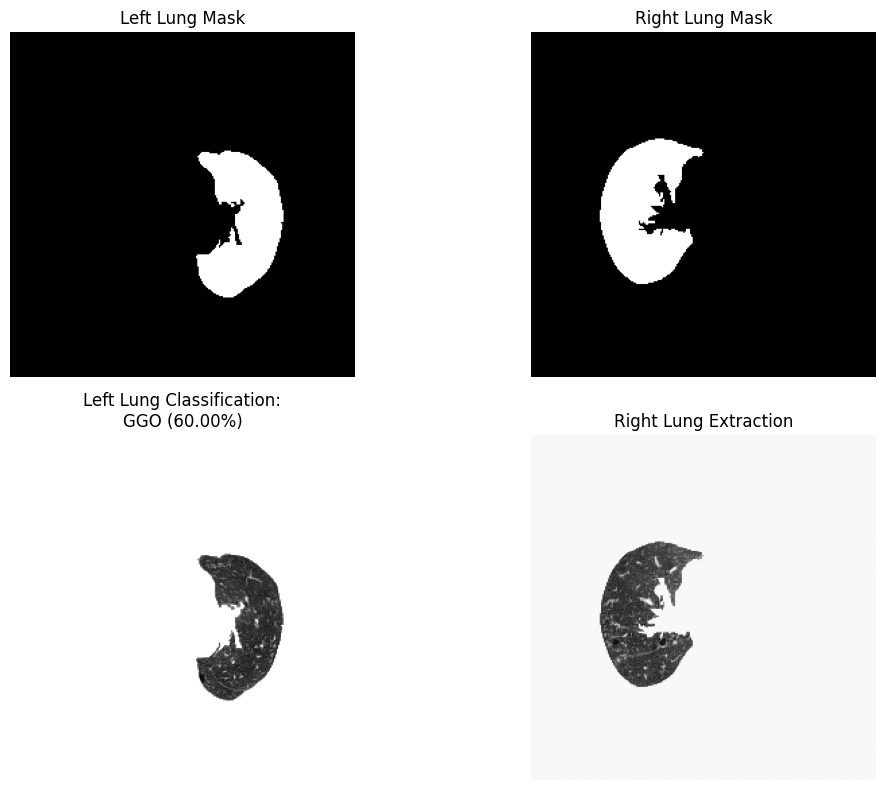

✅ Processed 0774.dcm - Classification: GGO (60.00%)


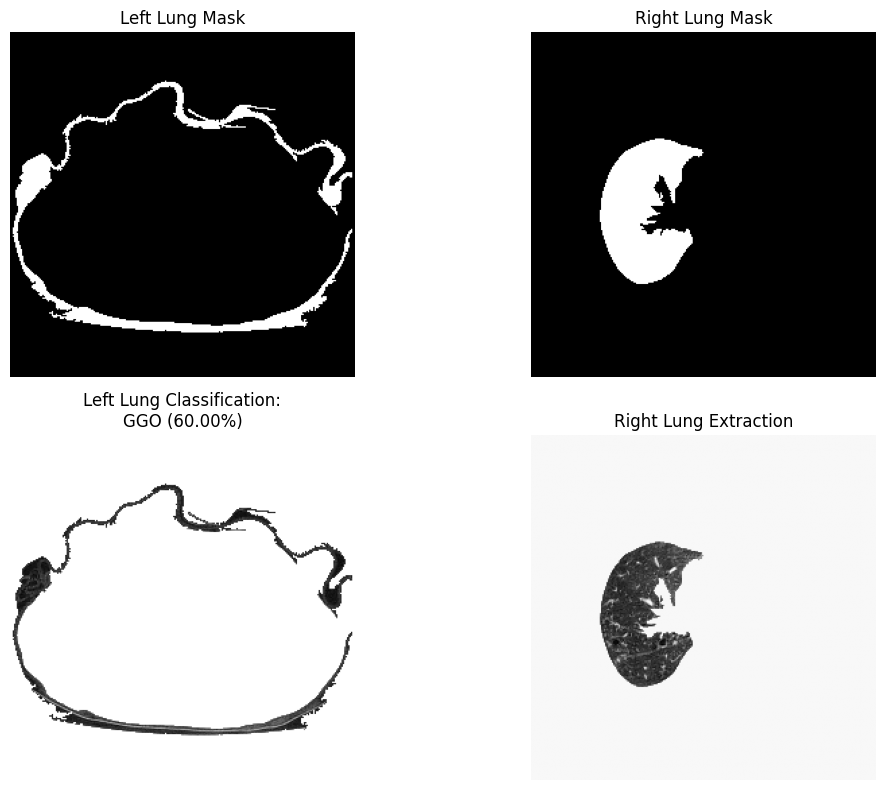

✅ Processed 0775.dcm - Classification: GGO (60.00%)


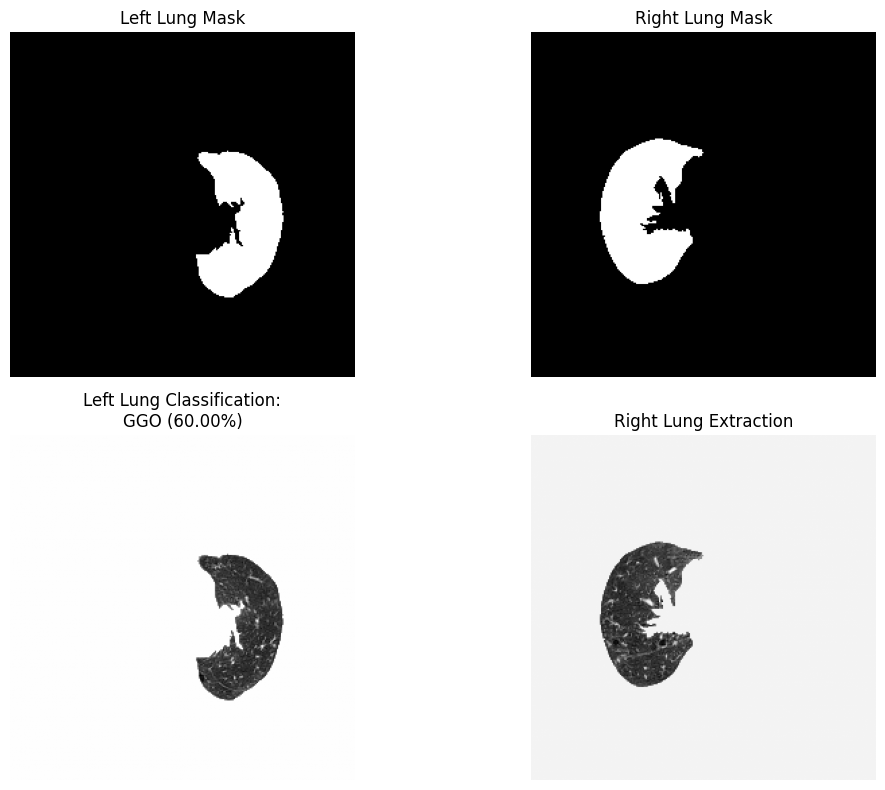

✅ Processed 0776.dcm - Classification: GGO (60.00%)


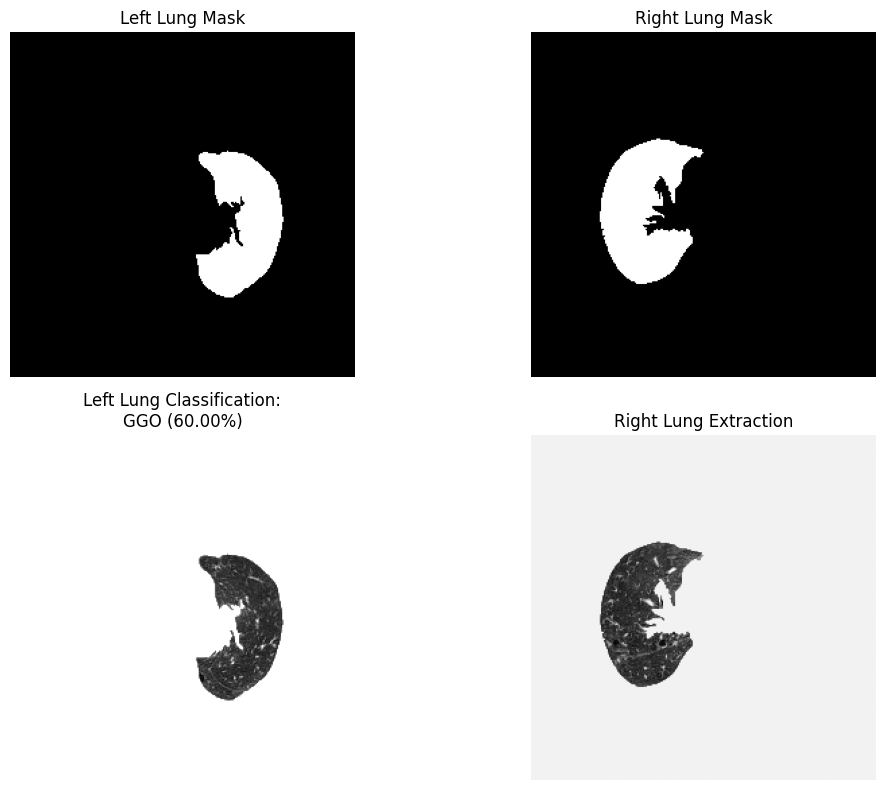

✅ Processed 0777.dcm - Classification: GGO (60.00%)


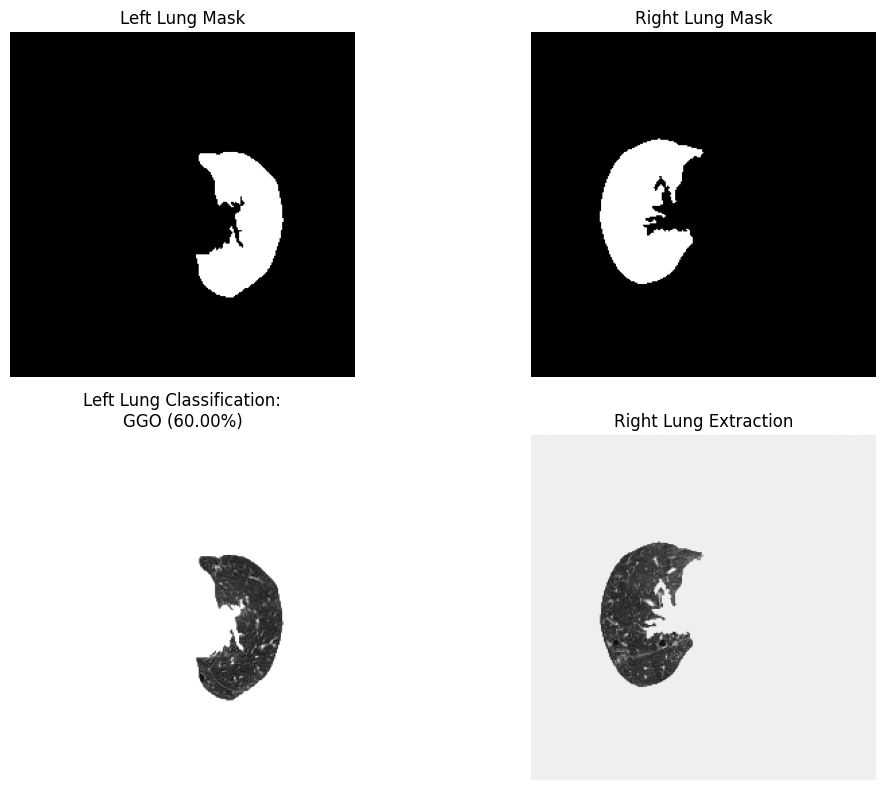

✅ Processed 0778.dcm - Classification: GGO (60.00%)


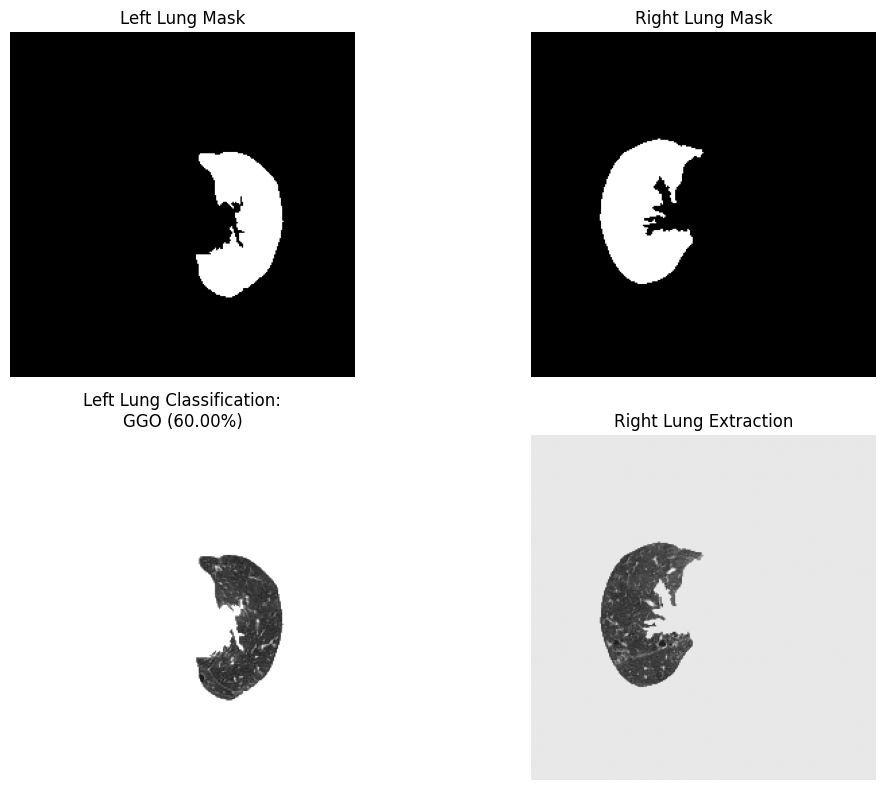

✅ Processed 0779.dcm - Classification: GGO (60.00%)


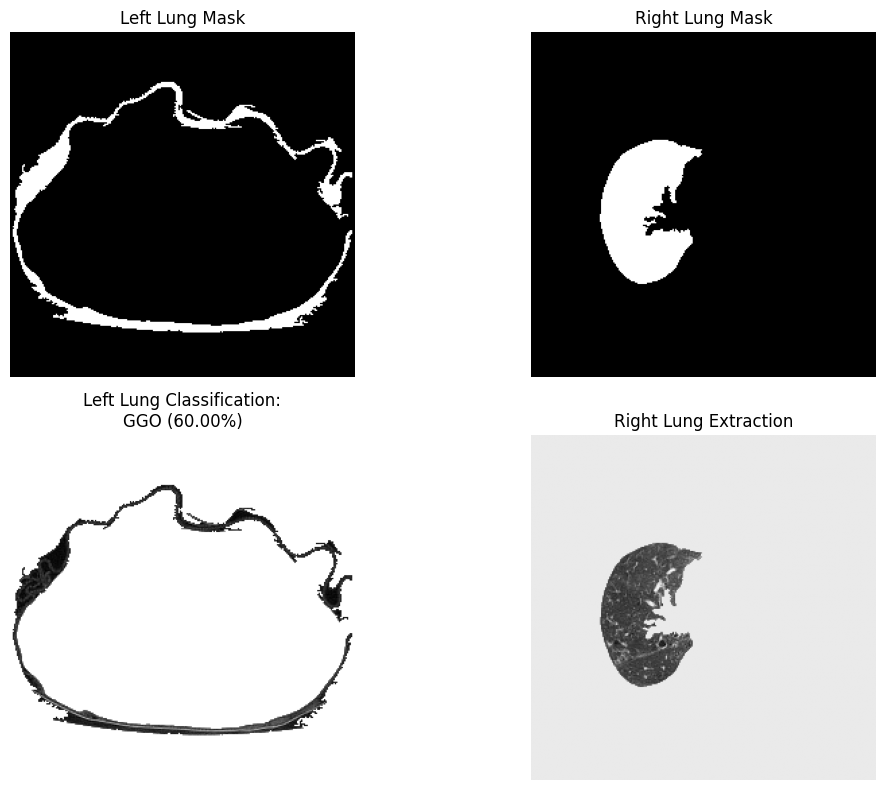

✅ Processed 0780.dcm - Classification: GGO (60.00%)


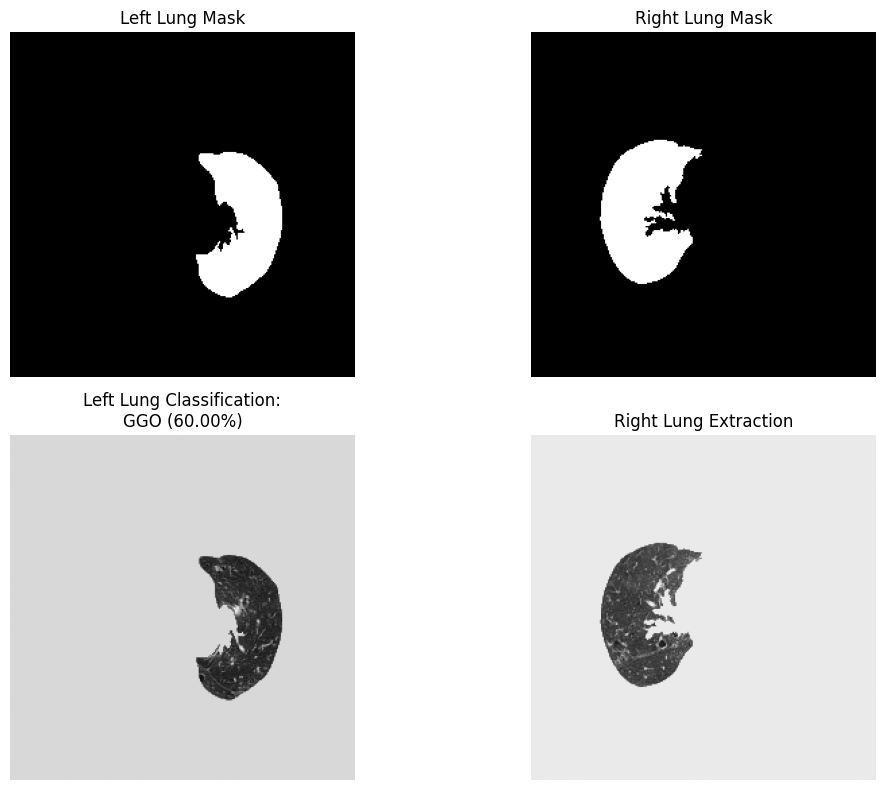

✅ Processed 0781.dcm - Classification: GGO (60.00%)
🎯 Completed processing all images!


In [ ]:
# @title Lung Prediction Of All Parts CT Images {"display-mode":"both"}
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
from skimage.feature import graycomatrix, graycoprops

# Ensure Matplotlib displays plots inline (for Jupyter/Colab)
%matplotlib inline

# -------------------- Define Paths --------------------
folder_path = r"/content/drive/MyDrive/ALLlungimg/Normal/P253/Series4"
output_folder = "./lung_outputs"
os.makedirs(output_folder, exist_ok=True)

# -------------------- Helper Functions --------------------
def load_dicom(dicom_path):
    """
    Load a DICOM file and convert it to Hounsfield Units (HU).
    """
    dicom_image = pydicom.dcmread(dicom_path)
    image_array = dicom_image.pixel_array.astype(np.float32)
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    hu_image = image_array * slope + intercept
    hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)
    return hu_resized

def create_lung_masks(hu_image):
    """
    Create binary masks for the left and right lungs.
    """
    lung_mask = (hu_image > -950) & (hu_image < -400)
    lung_mask_filled = binary_fill_holes(lung_mask)
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask_filled, min_size=1500)

    labeled_mask = label(lung_mask_cleaned)
    regions = regionprops(labeled_mask)
    if len(regions) < 2:
        return None, None  # If lung regions are missing
    regions = sorted(regions, key=lambda r: r.area, reverse=True)[:2]
    regions_sorted_by_x = sorted(regions, key=lambda r: np.mean(r.coords[:, 1]))

    right_lung_region = regions_sorted_by_x[0]
    left_lung_region = regions_sorted_by_x[1]

    # Create binary masks (set to 255 for visibility, as per your previous request)
    right_lung_mask = np.zeros_like(hu_image, dtype=np.uint8)
    for coord in right_lung_region.coords:
        right_lung_mask[coord[0], coord[1]] = 255

    left_lung_mask = np.zeros_like(hu_image, dtype=np.uint8)
    for coord in left_lung_region.coords:
        left_lung_mask[coord[0], coord[1]] = 255

    return left_lung_mask, right_lung_mask

def normalize_img(img):
    """
    Normalize image to range [0, 1] for visualization and texture analysis.
    """
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
    return img

def extract_features(lung_image, lung_mask):
    """
    Extract features (HU statistics and texture) from the lung region.
    """
    # Apply mask to isolate lung region
    lung_region = lung_image * (lung_mask / 255)  # Scale mask to 0 or 1
    lung_hu_values = lung_region[lung_mask == 255]  # Only consider masked region

    # Compute HU statistics
    mean_hu = np.mean(lung_hu_values) if len(lung_hu_values) > 0 else 0
    std_hu = np.std(lung_hu_values) if len(lung_hu_values) > 0 else 0

    # Convert lung region to 8-bit for texture analysis
    lung_8bit = (normalize_img(lung_region) * 255).astype(np.uint8)

    # Compute texture features using Gray-Level Co-occurrence Matrix (GLCM)
    glcm = graycomatrix(lung_8bit, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return mean_hu, std_hu, contrast, homogeneity

def classify_lung(mean_hu, std_hu, contrast, homogeneity):
    """
    Classify lung condition based on extracted features.
    """
    classes = ["Normal", "GGO", "Consolidation", "Crazy Paving", "Fibrosis"]

    # Normal: Low HU, homogeneous texture
    if mean_hu < -700 and std_hu < 100 and homogeneity > 0.5:
        return classes[0], 0.9  # Normal

    # GGO: Slightly higher HU, moderate homogeneity
    elif -700 <= mean_hu <= -300 and std_hu < 150 and homogeneity > 0.4:
        return classes[1], 0.85  # GGO

    # Consolidation: High HU, low homogeneity
    elif mean_hu > -100 and std_hu > 100 and homogeneity < 0.3:
        return classes[2], 0.9  # Consolidation

    # Crazy Paving: Mixed HU, high contrast (due to septal thickening)
    elif -700 <= mean_hu <= -300 and contrast > 50 and homogeneity < 0.4:
        return classes[3], 0.87  # Crazy Paving

    # Fibrosis: Irregular HU, high contrast (due to scarring)
    elif mean_hu > -300 and contrast > 70 and homogeneity < 0.3:
        return classes[4], 0.88  # Fibrosis

    # Default: If no clear match, classify as GGO (common in ambiguous cases)
    return classes[1], 0.6  # GGO

# -------------------- Process Folder --------------------
dicom_files = [f for f in os.listdir(folder_path) if f.endswith(".dcm")]
print(f"Found {len(dicom_files)} DICOM files.")

for idx, filename in enumerate(dicom_files):
    file_path = os.path.join(folder_path, filename)
    try:
        # Load and preprocess the DICOM image
        hu_image = load_dicom(file_path)
        left_mask, right_mask = create_lung_masks(hu_image)

        if left_mask is None or right_mask is None:
            print(f"❌ Could not detect lungs for {filename}")
            continue

        # Extract lungs
        left_lung = hu_image * (left_mask / 255)
        right_lung = hu_image * (right_mask / 255)

        # Extract features from the left lung
        mean_hu, std_hu, contrast, homogeneity = extract_features(left_lung, left_mask)

        # Classify the left lung based on features
        predicted_label, confidence = classify_lung(mean_hu, std_hu, contrast, homogeneity)

        # Display/save
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.title("Left Lung Mask")
        plt.imshow(left_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.title("Right Lung Mask")
        plt.imshow(right_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.title(f"Left Lung Classification:\n{predicted_label} ({confidence*100:.2f}%)")
        plt.imshow(normalize_img(left_lung), cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.title("Right Lung Extraction")
        plt.imshow(normalize_img(right_lung), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        save_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_result.png")
        plt.savefig(save_path)
        plt.show()  # Display the plot on-screen

        print(f"✅ Processed {filename} - Classification: {predicted_label} ({confidence*100:.2f}%)")

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")

print(" Completed processing all images!")

In [ ]:
# @title Predication Of Whole Folder By Using U-net Model
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
from skimage.feature import graycomatrix, graycoprops

# -------------------- Define Paths --------------------
folder_path = r"/content/drive/MyDrive/150img5/Severe"
output_folder = "./lung_outputs"
os.makedirs(output_folder, exist_ok=True)

# -------------------- Helper Functions --------------------
def load_dicom(dicom_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image_array = dicom_image.pixel_array.astype(np.float32)
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    hu_image = image_array * slope + intercept
    hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)
    return hu_resized

def create_lung_masks(hu_image):
    # Threshold for lung tissue
    lung_mask = (hu_image > -950) & (hu_image < -400)
    lung_mask_filled = binary_fill_holes(lung_mask)
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask_filled, min_size=1500)

    labeled_mask = label(lung_mask_cleaned)
    regions = regionprops(labeled_mask)
    if len(regions) < 2:
        return None, None  # If lung regions are missing
    regions = sorted(regions, key=lambda r: r.area, reverse=True)[:2]
    regions_sorted_by_x = sorted(regions, key=lambda r: np.mean(r.coords[:, 1]))

    right_lung_region = regions_sorted_by_x[0]
    left_lung_region = regions_sorted_by_x[1]

    right_lung_mask = np.zeros_like(hu_image, dtype=np.uint8)
    for coord in right_lung_region.coords:
        right_lung_mask[coord[0], coord[1]] = 1

    left_lung_mask = np.zeros_like(hu_image, dtype=np.uint8)
    for coord in left_lung_region.coords:
        left_lung_mask[coord[0], coord[1]] = 1

    return left_lung_mask, right_lung_mask

def normalize_img(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)
    return img

def extract_features(lung_image, lung_mask):
    # Apply mask to isolate lung region
    lung_region = lung_image * lung_mask

    # Compute HU statistics
    lung_hu_values = lung_region[lung_mask == 1]
    mean_hu = np.mean(lung_hu_values)
    std_hu = np.std(lung_hu_values)

    # Convert lung region to 8-bit for texture analysis
    lung_8bit = (normalize_img(lung_region) * 255).astype(np.uint8)

    # Compute texture features using Gray-Level Co-occurrence Matrix (GLCM)
    glcm = graycomatrix(lung_8bit, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return mean_hu, std_hu, contrast, homogeneity

def classify_lung(mean_hu, std_hu, contrast, homogeneity):
    # Rule-based classification based on features
    classes = ["Normal", "GGO", "Consolidation", "Crazy Paving", "Fibrosis"]

    # Normal: Low HU, homogeneous texture
    if mean_hu < -700 and std_hu < 100 and homogeneity > 0.5:
        return classes[0], 0.9  # Normal

    # GGO: Slightly higher HU, moderate homogeneity
    elif -700 <= mean_hu <= -300 and std_hu < 150 and homogeneity > 0.4:
        return classes[1], 0.85  # GGO

    # Consolidation: High HU, low homogeneity
    elif mean_hu > -100 and std_hu > 100 and homogeneity < 0.3:
        return classes[2], 0.9  # Consolidation

    # Crazy Paving: Mixed HU, high contrast (due to septal thickening)
    elif -700 <= mean_hu <= -300 and contrast > 50 and homogeneity < 0.4:
        return classes[3], 0.87  # Crazy Paving

    # Fibrosis: Irregular HU, high contrast (due to scarring)
    elif mean_hu > -300 and contrast > 70 and homogeneity < 0.3:
        return classes[4], 0.88  # Fibrosis

    # Default: If no clear match, classify as GGO (common in ambiguous cases)
    return classes[1], 0.6  # GGO

# -------------------- Process Folder --------------------
dicom_files = [f for f in os.listdir(folder_path) if f.endswith(".dcm")]
print(f"Found {len(dicom_files)} DICOM files.")

for idx, filename in enumerate(dicom_files):
    file_path = os.path.join(folder_path, filename)
    try:
        # Load and preprocess the DICOM image
        hu_image = load_dicom(file_path)
        left_mask, right_mask = create_lung_masks(hu_image)

        if left_mask is None or right_mask is None:
            print(f"Could not detect lungs for {filename}")
            continue

        # Extract lungs
        left_lung = hu_image * left_mask
        right_lung = hu_image * right_mask

        # Extract features from the left lung
        mean_hu, std_hu, contrast, homogeneity = extract_features(left_lung, left_mask)

        # Classify the left lung based on features
        predicted_label, confidence = classify_lung(mean_hu, std_hu, contrast, homogeneity)

        # Display/save
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.title("Left Lung Mask")
        plt.imshow(left_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.title("Right Lung Mask")
        plt.imshow(right_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.title(f"Left Lung Classification:\n{predicted_label} ({confidence*100:.2f}%)")
        plt.imshow(normalize_img(left_lung), cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.title("Right Lung Extraction")
        plt.imshow(normalize_img(right_lung), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        save_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_result.png")
        plt.savefig(save_path)
        plt.close()

        print(f"✅ Processed {filename} - Classification: {predicted_label} ({confidence*100:.2f}%)")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("Completed processing all images!")

Found 18 DICOM files.
✅ Processed 0457.dcm - Classification: GGO (60.00%)
✅ Processed 0455.dcm - Classification: GGO (60.00%)
✅ Processed 0463.dcm - Classification: GGO (60.00%)
✅ Processed 0461.dcm - Classification: GGO (60.00%)
✅ Processed 0452.dcm - Classification: GGO (60.00%)
✅ Processed 0443.dcm - Classification: Normal (90.00%)
✅ Processed 0459.dcm - Classification: GGO (60.00%)
✅ Processed 0447.dcm - Classification: GGO (60.00%)
✅ Processed 0467.dcm - Classification: GGO (60.00%)
✅ Processed 0478.dcm - Classification: GGO (60.00%)
✅ Processed 0480.dcm - Classification: GGO (60.00%)
✅ Processed 0476.dcm - Classification: GGO (60.00%)
✅ Processed 0466.dcm - Classification: GGO (60.00%)
✅ Processed 0481.dcm - Classification: GGO (60.00%)
✅ Processed 0483.dcm - Classification: GGO (60.00%)
✅ Processed 0472.dcm - Classification: GGO (60.00%)
✅ Processed 0475.dcm - Classification: GGO (60.00%)
✅ Processed 0477.dcm - Classification: GGO (60.00%)
Completed processing all images!
